<a href="https://colab.research.google.com/github/GiovaniValdrighi/inferencia_causal/blob/master/vae/model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code for the training process of the Variational AutoEncoder network

## 1.Getting acess to the dataset on Google Drive



In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## 2.Installing Pyro and calling the modules

In [6]:
!pip3 install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl
!pip3 install torchvision
!pip3 install pyro-ppl

ERROR: torch-0.4.0-{platform}-linux_x86_64.whl is not a valid wheel filename.


In [0]:
import torch
import pyro
import numpy as np
from torch.nn import Module
from torch.nn.functional import one_hot
from networks import Decoder, Encoder
from torch import tensor
from pyro.distributions import OneHotCategorical, Normal, Bernoulli, Uniform
import matplotlib.pyplot as plt

def setup_data_loader(images, classes, batch_size = 128, use_CUDA = False):
    '''
    Function that receives two arrays, an array of the data images and an array of it latents values
    and generate a DataLoader for train and test data.
    
    Input:
    :images: array of size [*, 64, 64] with images data
    :classes: array of size [*, 6] with latent variables of the images
    
    Output:
    :train_loader: torch data loader with train data (images and latents)
    :test_loader: torch data loader with test data (images and latents)
    '''
    index = np.random.permutation(images.shape[0])
    images = images[index].astype(np.float32)
    classes = classes[index].astype(np.float32)
    rt = int(np.ceil(images.shape[0]/10))
    train_df = torch.utils.data.TensorDataset(torch.from_numpy(images[rt:].reshape(-1, 4096)), torch.from_numpy(classes[rt:]))
    test_df = torch.utils.data.TensorDataset(torch.from_numpy(images[:rt].reshape(-1, 4096)), torch.from_numpy(classes[:rt]))
    kwargs = {'num_workers': 1, 'pin_memory': use_CUDA}
    train_loader = torch.utils.data.DataLoader(train_df, batch_size, shuffle = False, **kwargs)
    test_loader = torch.utils.data.DataLoader(test_df, batch_size, shuffle = False, **kwargs)
    return train_loader, test_loader


class VAE(Module):
    '''
    Class that define the posterior distribution q(z|x) as the model 
    with the decoder and the prior distribution q(x|z) as the guide 
    using the encoder.
    
    Inputs:  
    :pimg_dim: dimension of image vector
    :label_dim: dimension of label vector
    :latent_dim: dimension of Z space, output
    '''
    def __init__(self, img_dim = 4096, label_dim = 114, latent_dim = 200, use_CUDA = False):
        super(VAE, self).__init__()
        #creating networks
        self.encoder = Encoder(img_dim, label_dim, latent_dim)
        self.decoder = Decoder(img_dim, label_dim, latent_dim)
        self.img_dim = img_dim
        self.label_dim = label_dim
        self.latent_dim = latent_dim
        if use_CUDA:
            self.cuda()
        self.use_CUDA = use_CUDA
  
    def label_variable(self, label):
        options = {'device': label.device, 'dtype': label.dtype}

        shape = pyro.sample("label_shape", 
            OneHotCategorical(torch.ones(label.shape[0], 3, **options) / (3.0)), 
            obs = one_hot((label[:, 0] - 1.).to(torch.int64), 3).to(torch.float32))
        scale = pyro.sample("label_scale",
            Uniform(torch.ones(label.shape[0], 1, **options)*0.5, torch.ones(label.shape[0], 1, **options)*1.0001).to_event(1),
            obs = label[:, 1].reshape(label.shape[0], 1))
        orien = pyro.sample("label_orien",
            Uniform(torch.zeros(label.shape[0], 1, **options), torch.ones(label.shape[0], 1, **options)*2*(np.pi+0.001)).to_event(1),
            obs = label[:, 2].reshape(label.shape[0], 1))
        posX = pyro.sample("label_posX",
            Uniform(torch.zeros(label.shape[0], 1, **options), torch.ones(label.shape[0], 1, **options)*1.0001).to_event(1),
            obs = label[:, 3].reshape(label.shape[0], 1))
        posY = pyro.sample("label_posY",
            Uniform(torch.zeros(label.shape[0], 1, **options), torch.ones(label.shape[0], 1, **options)*1.0001).to_event(1),
            obs = label[:, 4].reshape(label.shape[0], 1))

        new_label = torch.cat([shape, scale, orien, posX, posY], -1).to(dtype = torch.float32, device = label.device)
        return new_label

    def model(self, img, label):
        pyro.module("decoder", self.decoder)
        options = {'device': img.device, 'dtype': img.dtype}
        with pyro.plate("data", img.shape[0]):
            z_mean = torch.zeros(img.shape[0], self.latent_dim, **options)
            z_variance = torch.ones(img.shape[0], self.latent_dim, **options)
            z_sample = pyro.sample("latent", Normal(z_mean, z_variance).to_event(1))
            image = self.decoder.forward(z_sample, self.label_variable(label))
            pyro.sample("obs", Bernoulli(image).to_event(1), obs = img)


    def guide(self, img, label):
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", img.shape[0]):
            z_mean, z_variance = self.encoder.forward(img, self.label_variable(label))
            pyro.sample("latent", Normal(z_mean, z_variance).to_event(1))

In [14]:
dataset_zip = np.load('/content/gdrive/My Drive/autoencoder/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz', allow_pickle = True, encoding = 'bytes')
print('Keys in the dataset:', dataset_zip.files)
imgs = dataset_zip['imgs']
latents_values = dataset_zip['latents_values']
latents_classes = dataset_zip['latents_classes']
latents_sizes = dataset_zip['metadata'][()][b'latents_sizes']
latents_names = dataset_zip['metadata'][()][b'latents_names']

Keys in the dataset: ['metadata', 'imgs', 'latents_classes', 'latents_values']


## 3.The training process
In the following training process, we use the Standart variational inference from Pyro. In each testing iteration the state of the model (parameters values of the network) are saved at the Google Drive with the number of epochs in the file name.

In [0]:
pyro.enable_validation(True)
pyro.clear_param_store()
use_CUDA = True
train_loader, test_loader = setup_data_loader(imgs, latents_values[:, 1:6], use_CUDA = use_CUDA)
vae = VAE(label_dim= 7, use_CUDA = use_CUDA)

In [51]:
#optimizer
optimizer = pyro.optim.Adam({"lr" : 1.0e-3})

#inference algorithm
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(vae.model, vae.guide, optimizer, elbo)

train_elbo = []
test_elbo = []
num_epochs = 80
test_freq = 10
for epoch in range(num_epochs):
  epoch_loss = 0.
  for (img, label) in train_loader:
    if use_CUDA:
      img = img.cuda()
      label = label.to(img.device)
    epoch_loss += svi.step(img, label)
  total_epoch_loss_train = epoch_loss/len(train_loader)
  train_elbo.append(total_epoch_loss_train)
  print("epoch: " + str(epoch) + " average training loss: " + str(epoch_loss))

  if epoch % test_freq == 0:
    test_loss = 0
    for (img, label) in test_loader:
      if use_CUDA:
        img = img.cuda()
        label = label.to(img.device)
      test_loss += svi.evaluate_loss(img, label)
    total_epoch_loss_test  = epoch_loss/len(test_loader)
    test_elbo.append(total_epoch_loss_test)
    print("epoch: " + str(epoch) + " average testing loss: " + str(test_loss))
    print("Saved at Google Drive.")
    torch.save(vae.state_dict(), '/content/gdrive/My Drive/trained_movel_epoch_'+ str(epoch) + '.save')

/usr/local/lib/python3.6/dist-packages/pyro/util.py:208: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'label_scale', 'label_orien', 'label_shape', 'label_posX', 'label_posY'}
  guide_vars - aux_vars - model_vars))


epoch: 0 average training loss: 81948158.9428711
epoch: 0 average testing loss: 6299776.04296875
Saved at Google Drive.
epoch: 1 average training loss: 52626446.6484375
epoch: 2 average training loss: 48236607.47216797
epoch: 3 average training loss: 46163292.93457031
epoch: 4 average training loss: 44822159.15136719
epoch: 5 average training loss: 43832432.96826172
epoch: 6 average training loss: 43049161.24511719
epoch: 7 average training loss: 42401082.385253906
epoch: 8 average training loss: 41833364.482421875
epoch: 9 average training loss: 41370089.768066406
epoch: 10 average training loss: 40996013.076660156
epoch: 10 average testing loss: 4551739.119140625
Saved at Google Drive.
epoch: 11 average training loss: 40635289.66503906
epoch: 12 average training loss: 40314577.0090332
epoch: 13 average training loss: 40019163.427246094
epoch: 14 average training loss: 39683063.35888672
epoch: 15 average training loss: 39458649.74316406
epoch: 16 average training loss: 55765690.413085

ValueError: ignored

tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, n

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


ValueError: ignored

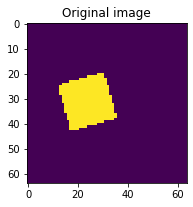

In [81]:
def run_img(vae, img, label, num = 2):
  shape = one_hot(tensor(label[0] - 1).to(torch.int64), 3).to(torch.float32)
  label = torch.cat([shape, tensor(label[1:]).to(torch.float32)]).to(torch.float32).cuda()
  img = tensor(img.reshape(4096)).to(torch.float32).cuda()
  label = label.cuda()
  img = img.cuda()
  mean, var = vae.encoder.forward(img, label)

  fig = plt.figure(figsize = (4, num*5))
  plots = []
  plots.append(plt.subplot(num+1, 1, 1))
  plots[0].set_title('Original image')
  plt.imshow(img.cpu().reshape(64, 64))
  
  print(mean)
  for i in range(1, num):
    z_sample = Normal(mean, var).sample()
    vae_img = vae.decoder.forward(z_sample, dummy_label)
    plots.append(plt.subplot(num+1, 1, i+1))
    plots[-1].set_title(str(i) +' - sample of latent space')
    plt.imshow(vae_img.cpu().detach().numpy().reshape(64, 64))
  plt.show()
run_img(vae, img[0], latents_values[0][1:])

In [72]:
latents_values[0][1:]

array([1. , 0.5, 0. , 0. , 0. ])

In [67]:
run_img(vae, img[0], latents_values[0][1:6])

RuntimeError: ignored

In [0]:
a = tensor([0., 1., 2.])
b = tensor([3., 4., 5.])

tensor([5., 6., 7.])

In [58]:
a[2:3]

tensor([2.])